# Setup

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
# For colab
if IN_COLAB:
  import sys
  !git clone https://github.com/elements72/EDiReF-subtask-III.git
  %pip install lightning
  %pip install wandb
  sys.path.append('./EDiReF-subtask-III')
  %cd ./EDiReF-subtask-III
  num_workers = 2
else:
  num_workers = 0
  pass

In [2]:
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)

In [3]:
# Reload modules, do not use cache
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import numpy as np
from utils import train_model, hyperparameters_tuning, train_model_seeds
import torch
from baselines import random_metrics, majority_metrics, aggregate_results
from baselines import BertBaseline
from baselines import RandomUniformClassifier
from baselines import MajorityClassifier
from metrics import F1ScoreCumulative, F1ScoreDialogues
import torch
from sklearn.model_selection import train_test_split
from attention import DialoguesAttention
from lstm_model import LSTMResModel
from dataset import MeldDataModule
from bertrig import BERTrig


Using device: cuda


In [5]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antonio-lopez (nlp-ediref). Use `wandb login --relogin` to force relogin


True

# Dataset

In [6]:
batch_size = 2
# Create and setup data module
datamodule = MeldDataModule(batch_size=batch_size, num_workers=num_workers)
datamodule.prepare_data()
datamodule.setup()
# Get dataframes
train_data = datamodule.train_data
val_data = datamodule.val_data
test_data = datamodule.test_data
# Get encoder
emotion_encoder = datamodule.emotion_encoder
#Base Dataloaders
train_loader = datamodule.train_dataloader(collate_context='sentence', batch_size=batch_size)
val_loader = datamodule.val_dataloader(collate_context='sentence', batch_size=batch_size)
test_loader = datamodule.test_dataloader(collate_context='sentence', batch_size=batch_size)

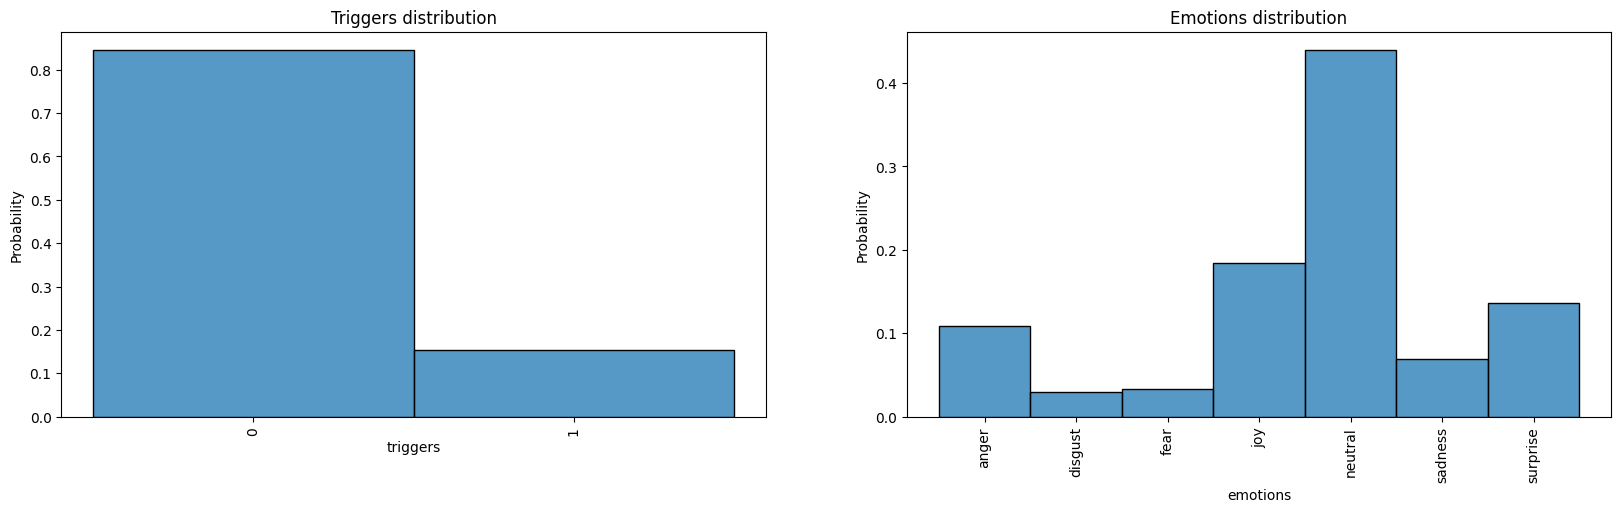

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

class_weights_emotion = compute_class_weight('balanced', classes=np.unique(train_data['emotions'].explode()),
                                             y=train_data['emotions'].explode())
class_weights_emotion = torch.tensor(class_weights_emotion, dtype=torch.float)

class_weights_trigger = compute_class_weight('balanced', classes=np.unique(train_data['triggers'].explode()), 
                                             y=train_data['triggers'].explode())
class_weights_trigger = torch.tensor(class_weights_trigger, dtype=torch.float)

class_weights_emotion



# Plot side by side
x_labels = ["0", "1"]
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# Trigger distribution
ax = sns.histplot(train_data['triggers'].explode(), stat='probability', discrete=True, ax=axes[0])#, x=x_labels)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_title("Triggers distribution")
# Emotion distribution
x_labels = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
ax = sns.histplot(train_data['emotions'].explode(), stat='probability', discrete=True, ax=axes[1])#, x=x_labels)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_title("Emotions distribution")
plt.show()

xlabels = emotion_encoder.classes_.tolist()

In [8]:
def get_hyperparams(model_name, freeze, lr):
    hyperparameters = {
        "lr": lr,
        "class_weights_emotion": class_weights_emotion,
        "class_weights_trigger": class_weights_trigger,
        "hidden_layers": 2,
        "use_encoder_cache": True if freeze else False,
        "encoder_cache_size": 100000,
        "freeze_bert": freeze,
        "dropout": 0.2,
        "bert_model_name": "bert-base-uncased",
        }
    if "lstm" in model_name:
        lstm_kwargs = {
            "hidden_size": 128,
            "num_layers": 2,
            "bidirectional": False,
        }
        hyperparameters["lstm_kwargs"] = lstm_kwargs
    if "emoberta" in model_name:
        hyperparameters["bert_model_name"] = "tae898/emoberta-large"
    if "bert-trig" in model_name:
        hyperparameters = {
            "lr": 1e-4,
            "class_weights_emotion": class_weights_emotion,
            "class_weights_trigger": class_weights_trigger,
            "hidden_layers": 2,
            "encoder_cache_size": 10000,
            "dropout": 0.2,
            }

    return hyperparameters


In [9]:
lr = 1e-3
epochs = 20
tune_hyperparameters = False
train = False
seeds = [6, 9, 42, 150, 300]

batch_size_freeze = 32
batch_size_unfreeze = 8

train_loader_freeze = datamodule.train_dataloader(collate_context='sentence', batch_size=batch_size_freeze )
val_loader_freeze = datamodule.val_dataloader(collate_context='sentence', batch_size=batch_size_freeze   )
test_loader_freeze = datamodule.test_dataloader(collate_context='sentence', batch_size=batch_size_freeze  )

train_loader_unfreeze = datamodule.train_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)
val_loader_unfreeze = datamodule.val_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)
test_loader_unfreeze = datamodule.test_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)

train_loader_emoberta = datamodule.train_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)
val_loader_emoberta = datamodule.val_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)
test_loader_emoberta = datamodule.test_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)



train_loader_bert_trig = datamodule.train_dataloader(collate_context='context_sentence', batch_size=1)
val_loader_bert_trig = datamodule.val_dataloader(collate_context='context_sentence', batch_size=1)
test_loader_bert_trig = datamodule.test_dataloader(collate_context='context_sentence', batch_size=1)



models = {
    "bert-baseline-freeze":{'model_class': BertBaseline, 'hyperparameters': get_hyperparams("bert-baseline-freeze", freeze=True, lr=lr), "train_loader": train_loader_freeze, "val_loader": val_loader_freeze},
    "bert-baseline-unfreeze":{'model_class': BertBaseline, 'hyperparameters': get_hyperparams("bert-baseline-unfreeze", freeze=False, lr=lr), "train_loader": train_loader_unfreeze, "val_loader": val_loader_unfreeze},
    "bert-lstm-freeze":{'model_class': LSTMResModel, 'hyperparameters': get_hyperparams("bert-lstm-freeze", freeze=True, lr=lr), "train_loader": train_loader_freeze, "val_loader": val_loader_freeze},
    "bert-lstm-unfreeze":{'model_class': LSTMResModel, 'hyperparameters': get_hyperparams("bert-lstm-unfreeze", freeze=False, lr=lr), "train_loader": train_loader_unfreeze, "val_loader": val_loader_unfreeze},
    "bert-attention-freeze":{'model_class': DialoguesAttention, 'hyperparameters': get_hyperparams("bert-attention-freeze", freeze=True, lr=lr), "train_loader": train_loader_freeze, "val_loader": val_loader_freeze},
    "bert-attention-unfreeze":{'model_class': DialoguesAttention, 'hyperparameters': get_hyperparams("bert-attention-unfreeze", freeze=False, lr=lr), "train_loader": train_loader_unfreeze, "val_loader": val_loader_unfreeze},
    "emoberta-current": {'model_class': BertBaseline, 'hyperparameters': get_hyperparams("emoberta", freeze=True, lr=lr), "train_loader": train_loader_emoberta, "val_loader": val_loader_emoberta},
    "emoberta-lstm": {'model_class': LSTMResModel, 'hyperparameters': get_hyperparams("emoberta-lstm", freeze=True, lr=lr), "train_loader": train_loader_emoberta, "val_loader": val_loader_emoberta},
    "bert-trig": {'model_class': BERTrig, 'hyperparameters': get_hyperparams("bert-trig", freeze=True, lr=lr), "train_loader": train_loader_bert_trig, "val_loader": val_loader_bert_trig},
    }

# to_train = ['emoberta']
# for model_name, model_dict in models.items():
#   if model_name not in to_train:
#     continue
#   train_model_seeds(**model_dict, model_name=model_name, seeds=seeds, epochs=epochs, wandb=wandb)

In [10]:
from utils import load_model, evaluate_model
import os

def eval(models, seeds, test=False, to_evaluate=None, load=True):
    results_path = Path("results")
    results_name = f"{'test' if test else 'val'}_results.csv"
    results = pd.DataFrame()
    # Try loading existing results
    if os.path.exists(results_path / results_name):
        results = pd.read_csv(results_path / results_name, index_col=0)
        if load:
            return results
    for model_name, model_dict in models.items():
        if to_evaluate is not None and model_name not in to_evaluate:
            continue
        if model_name == 'bert-trig':
            test_loader_evaluate = datamodule.test_dataloader(collate_context='context_sentence', batch_size=1)
            if not test:
                test_loader_evaluate = val_loader_bert_trig
        else:
            test_loader_evaluate = test_loader_unfreeze
            if not test:
                test_loader_evaluate = val_loader_unfreeze
        for seed in seeds:
            print(f"Evaluating {model_name} with seed {seed}    ")
            model = load_model(model_dict["model_class"], f"{model_name}-seed-{seed}")
            if model is None:
                continue
            result = evaluate_model(model, f"{model_name}-seed-{seed}", test_loader_evaluate, test=True, verbose=False)
            # If the model name is alreay in the results substitude it
            if f"{model_name}-seed-{seed}" in results.index:
                results.loc[model_name] = result
            else:
                results = pd.concat([results, result])
        # save results  
        results.to_csv(results_path / results_name, index=True)
    return results

In [275]:
load_results = True
test_results = eval(models, seeds, test=True, load=load_results)
val_results = eval(models, seeds, test=False, load=load_results)

In [276]:
test_results = test_results.drop(columns=["test_loss", "test_emotion_loss", "test_trigger_loss"])
val_results = val_results.drop(columns=["val_loss", "val_emotion_loss", "val_trigger_loss"])

In [277]:
# Compute mean and std for each column
test_results_aggregated = test_results.copy()
test_results_aggregated.index =  test_results_aggregated.index.str.replace("-seed-\d+", "")
test_results_aggregated = test_results_aggregated.groupby(level=0).agg(["mean", "std"])
test_results_aggregated

/tmp/ipykernel_43968/2701999117.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_results_aggregated.index =  test_results_aggregated.index.str.replace("-seed-\d+", "")


f1_test_cumulative_emotion            \
                                              mean       std   
model_name                                                     
bert-attention-freeze                     0.333387  0.022827   
bert-attention-unfreeze                   0.406844  0.023510   
bert-baseline-freeze                      0.360447  0.021234   
bert-baseline-unfreeze                    0.408425  0.013422   
bert-lstm-freeze                          0.365662  0.014246   
bert-lstm-unfreeze                        0.413969  0.009863   
bert-trig                                 0.637304  0.010282   
emoberta-current                          0.566634  0.014617   
emoberta-lstm                             0.607828  0.020437   

                        f1_test_cumulative_trigger            \
                                              mean       std   
model_name                                                     
bert-attention-freeze                     0.318745  0.025600   
bert-attention-unfreeze                   0.338968  0.007902   
bert-baseline-freeze                      0.279776  0.001793   
bert-baseline-unfreeze                    0.287504  0.007836   
bert-lstm-freeze                          0.339595  0.005212   
bert-lstm-unfreeze                        0.292828  0.008305   
bert-trig                                 0.275056  0.005800   
emoberta-current                          0.275746  0.012876   
emoberta-lstm                             0.314184  0.013018   

                        f1_test_cumulative_trigger_multi            \
                                                    mean       std   
model_name                                                           
bert-attention-freeze                           0.507598  0.094494   
bert-attention-unfreeze                         0.567124  0.012692   
bert-baseline-freeze                            0.395314  0.040571   
bert-baseline-unfreeze                          0.472265  0.015174   
bert-lstm-freeze                                0.569556  0.019693   
bert-lstm-unfreeze                              0.461105  0.019580   
bert-trig                                       0.465529  0.037414   
emoberta-current                                0.425285  0.032207   
emoberta-lstm                                   0.540059  0.056881   

                        f1_test_dialogues_emotion            \
                                             mean       std   
model_name                                                    
bert-attention-freeze                    0.325227  0.048917   
bert-attention-unfreeze                  0.400479  0.016463   
bert-baseline-freeze                     0.342467  0.035196   
bert-baseline-unfreeze                   0.399961  0.017134   
bert-lstm-freeze                         0.354995  0.024368   
bert-lstm-unfreeze                       0.404116  0.026548   
bert-trig                                0.620521  0.006983   
emoberta-current                         0.538498  0.019573   
emoberta-lstm                            0.564226  0.019451   

                        f1_test_dialogues_trigger            \
                                             mean       std   
model_name                                                    
bert-attention-freeze                    0.281099  0.028775   
bert-attention-unfreeze                  0.293837  0.010580   
bert-baseline-freeze                     0.318977  0.006458   
bert-baseline-unfreeze                   0.312562  0.010616   
bert-lstm-freeze                         0.280746  0.026727   
bert-lstm-unfreeze                       0.325001  0.009811   
bert-trig                                0.292435  0.022880   
emoberta-current                         0.306650  0.024807   
emoberta-lstm                            0.256717  0.037354   

                        f1_test_dialogues_trigger_multi            
                                                   mean       s

In [14]:
# Random Classifier
# Test set
random_uniform_classifier = RandomUniformClassifier(7, 1)
metrics_random, emotions_predictions, triggers_predictions = random_metrics(random_uniform_classifier, test_loader, num_classes_emotions=7, num_classes_triggers=2)
# Validation set
metrics_random_val, emotions_predictions_val, triggers_predictions_val= random_metrics(random_uniform_classifier, val_loader, num_classes_emotions=7, num_classes_triggers=2)


# Majority Classifier
# Test set
majority_classifier = MajorityClassifier(num_classes_emotions=7, num_classes_triggers=2, padding_value_emotions=7, padding_value_triggers=2)
majority_classifier.fit(train_loader)
metrics_majority, emotions_predictions, triggers_predictions = majority_metrics(majority_classifier, test_loader, num_classes_emotions=7, num_classes_triggers=2)
# Validation set
metrics_majority_val, emotions_predictions_val, triggers_predictions_val = majority_metrics(majority_classifier, val_loader, num_classes_emotions=7, num_classes_triggers=2)
#Results
aggregated_results = aggregate_results(metrics_random, metrics_majority, metrics_random_val, metrics_majority_val)

aggregated_results

# Error analysis
Since EDiReF 2024 is about detection of emotion triggers the model with the best performance on the trigger is taken

In [ ]:
print((test_results_aggregated['f1_test_cumulative_emotion']['mean'] + test_results_aggregated['f1_test_cumulative_trigger']['mean']).idxmax())

emoberta-lstm


In [278]:
# Pick best model as average of trigger and emotion

best_model_name = (test_results['f1_test_cumulative_emotion'] + test_results['f1_test_cumulative_trigger']).idxmax()
best_model_key = best_model_name.split("-seed")[0]
# Load the best model
best_model = load_model(models[best_model_key]["model_class"], best_model_name, hyperparameters=models[best_model_key]["hyperparameters"])
best_model.eval()

/home/elements72/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.3, which is newer than your current Lightning version: v2.1.0


In [45]:
def model_predict(loader, model):
    y_pred = {"emotions": torch.Tensor().to('cpu'), "triggers": torch.Tensor().to('cpu')}
    y_true = {"emotions": torch.empty(0, dtype=torch.long).to('cpu'), "triggers": torch.empty(0, dtype=torch.long).to('cpu')}
    for batch in loader:
        preds = model.predict(batch)
        
        emotions = preds["emotions"].to('cpu')
        triggers = preds["triggers"].to('cpu')

        emotions = emotions.reshape(-1, model.emotion_output_dim)
        triggers = triggers.reshape(-1, model.trigger_output_dim)

        y_pred["emotions"] = torch.cat([y_pred["emotions"], emotions])
        y_pred["triggers"] = torch.cat([y_pred["triggers"], triggers])

        y_true["emotions"] = torch.cat([y_true["emotions"], batch["emotions"].reshape(-1).to('cpu')], dim=0)
        y_true["triggers"] = torch.cat([y_true["triggers"], batch["triggers"].reshape(-1).to('cpu')], dim=0)

    return y_pred, y_true

In [46]:
import matplotlib.pyplot as plt
from torchmetrics import PrecisionRecallCurve


def plot_precision_recall(y_pred, y_true, output_dim, labels):
    ignore_index = output_dim
    precision_curve = PrecisionRecallCurve(task="multiclass", num_classes=output_dim, ignore_index=ignore_index)

    print(y_pred.shape)
    curve = precision_curve(y_pred, y_true)
    precision, recall, _ = curve

    plt.figure(figsize=(15, 10))
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()

    emotion_to_auc = {}
    for i in range(output_dim):
        emotion = labels[i]
                
        auc = -1 * torch.trapz(precision[i], recall[i])
        
        emotion_to_auc[emotion] = auc.item()
        
        plt.plot(recall[i], precision[i], label=f"{emotion}: {auc:.2f}")

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


In [48]:
if "bert-trig" in best_model_key:
    test_loader = test_loader_bert_trig
else:
    test_loader = test_loader_unfreeze

In [50]:
y_pred, y_true = model_predict(test_loader, best_model)
plot_precision_recall(y_pred["emotions"], y_true["emotions"], best_model.emotion_output_dim, emotion_encoder.classes_)
plot_precision_recall(y_pred["triggers"], y_true["triggers"], best_model.trigger_output_dim, ["0", "1"])

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 1.95 GiB of which 2.38 MiB is free. Including non-PyTorch memory, this process has 1.95 GiB memory in use. Of the allocated memory 1.73 GiB is allocated by PyTorch, and 162.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
def plot_confusion_matrix(y_pred, y_true, labels, output_dim):
    ignore_index = output_dim

    confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=best_model.emotion_output_dim, ignore_index=ignore_index).to('cpu')

    y_pred_class = torch.argmax(y_pred, dim=1)

    confusion_matrix = confusion_matrix_metric(y_pred_class, y_true)

    # plot confusion matrix
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.imshow(confusion_matrix)
    plt.colorbar()
    plt.xticks(range(ignore_index), labels)
    plt.yticks(range(ignore_index), labels)
    # Insert values in the matrix
    for i in range(ignore_index):
        for j in range(ignore_index):
            plt.text(j, i, confusion_matrix[i, j].item(), ha="center", va="center", color="white" if confusion_matrix[i, j] > 100 else "black")

    # x ticks labels vertical
    plt.xticks(rotation=90)

    plt.show()
    return confusion_matrix

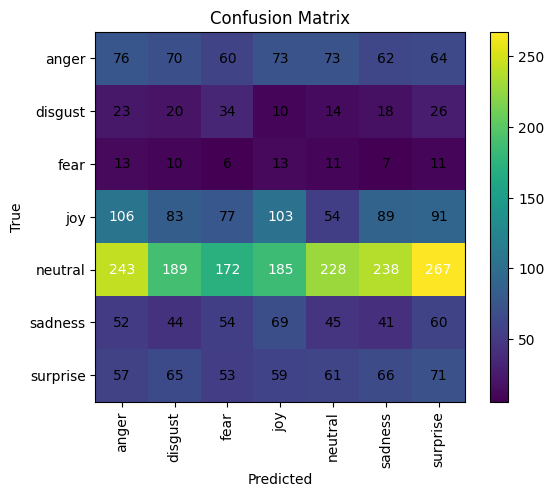

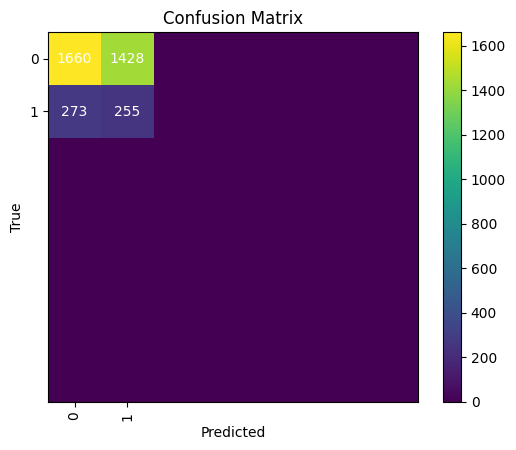

tensor([[1660, 1428,    0,    0,    0,    0,    0],
        [ 273,  255,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0]])

In [ ]:
emotion_confusion_matrix = plot_confusion_matrix(y_pred['emotions'], y_true['emotions'], emotion_encoder.classes_, best_model.emotion_output_dim)
plot_confusion_matrix(y_pred['triggers'], y_true['triggers'], ["0", "1"], best_model.trigger_output_dim);

In [ ]:
# Find the maximum value outside the diagonal
confused_emotion = {}
    
for i in range(best_model.emotion_output_dim):

    temp_row = emotion_confusion_matrix[i]
    temp_row[i] = -1
    
    # find the emotion that is most confused with the current emotion
    max_emotion = torch.argmax(temp_row)

    # Reverse lookup
    emotion_encoder.classes_[i]
    
    confused_emotion[emotion_encoder.classes_[i]] = {
        "confused_with": emotion_encoder.classes_[max_emotion],
        "n_errors": temp_row[max_emotion].item()
    }
    

top_k_most_confused = best_model.emotion_output_dim
most_confused = sorted(confused_emotion.items(), key=lambda x: x[1]["n_errors"], reverse=True)[:top_k_most_confused]

for i, (emotion, info) in enumerate(most_confused):
    print(f"Top {i + 1} most confused emotion: {emotion}, confused with {info['confused_with']} with {info['n_errors']} errors")


Top 1 most confused emotion: neutral, confused with surprise with 267 errors
Top 2 most confused emotion: joy, confused with anger with 106 errors
Top 3 most confused emotion: anger, confused with joy with 73 errors
Top 4 most confused emotion: sadness, confused with joy with 69 errors
Top 5 most confused emotion: surprise, confused with sadness with 66 errors
Top 6 most confused emotion: disgust, confused with fear with 34 errors
Top 7 most confused emotion: fear, confused with anger with 13 errors


In [55]:
import gc
gc.collect()

2099

In [56]:
torch.cuda.empty_cache()    

In [18]:
# Get most difficult dialogues
data = []
count = 0
for x in test_loader:
    #print(x)
    pred = best_model.pred(x, None, None)
    emotions_pred = pred["emotions"].tolist()
    emotions_true = x["emotions"].tolist()
    
    utterances = [item for sublist in x["utterances"] for item in sublist]
    emotions_pred = [item for sublist in emotions_pred for item in sublist]
    emotions_true = [item for sublist in emotions_true for item in sublist]
    dialog_id = [i + count for i in range(len(x["utterances"])) for _ in x['utterances'][i]]

    count += len(x['utterances'])
    
    trigger_pred = pred["triggers"].tolist()
    trigger_true = x["triggers"].tolist()
    
    trigger_pred = [item for sublist in trigger_pred for item in sublist]
    trigger_true = [item for sublist in trigger_true for item in sublist]
    
    # Utterances, emotion_pred, emotion_true are lists 
    
    data = data + list(zip(utterances, emotions_pred, emotions_true, trigger_pred, trigger_true, dialog_id))    
    

df = pd.DataFrame(columns=["utterances", "emotion_pred", "emotion_true", "trigger_pred", "trigger_true", "dialog_id"], data=data)
    
df["emotion_correct"] = df["emotion_pred"] == df["emotion_true"]
df["trigger_correct"] = df["trigger_pred"] == df["trigger_true"]

df["emotion_pred"] = df["emotion_pred"].apply(lambda x: emotion_encoder.classes_[x])
df["emotion_true"] = df["emotion_true"].apply(lambda x: emotion_encoder.classes_[x] if x != 7 else "<PAD>")

# Remove rows where emotion true is <PAD>
df = df[df["emotion_true"] != "<PAD>"]

In [19]:
# Create a new index level
df = df.set_index(["dialog_id", df.groupby("dialog_id").cumcount()])
# Make old index incremental

In [20]:
top_k = 3
# Get the most difficult dialogues
most_difficult_dialogues = df.groupby("dialog_id").mean().sort_values("emotion_correct", ascending=True).index[:top_k]
# Get most difficult dialogues for trigger
most_difficult_dialogues_trigger = df.groupby("dialog_id").mean().sort_values("trigger_correct", ascending=True).index[:top_k]

/tmp/ipykernel_43968/1384951695.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  most_difficult_dialogues = df.groupby("dialog_id").mean().sort_values("emotion_correct", ascending=True).index[:top_k]
/tmp/ipykernel_43968/1384951695.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  most_difficult_dialogues_trigger = df.groupby("dialog_id").mean().sort_values("trigger_correct", ascending=True).index[:top_k]


In [273]:
pd.set_option('display.max_colwidth', None)
# Get the most difficult dialogues without cutting the utterances column
df[df.index.get_level_values(0).isin(most_difficult_dialogues)]

utterances  \
dialog_id                                                                                        
174       0                                                  Rachel: What? Why? Where are you?   
          1                                                        Joey: I'm still on the set!   
          2                                 Rachel: Joey! The wedding is in less than an hour!   
          3  Joey: I know! I'm sorry! The guy's drunk, they won't let me go until we get this.   
          4                        Rachel: Oh my God! I'm gonna have to find another minister.   
279       0                            Joey: Hey, y'know what a really good rainy day game is?   
          1                                                                     Monica: What?!   
          2          Joey: I mean naked game. Strip poker, we should totally play strip poker.   
          3                                                                       All: No, no!   
          4                                                       Monica: What are you crazy?!   
          5            Joey: Come on! When you go away, you-you have to play, it's like a law!   
337       0                                               Chandler: Well, I feel like a snack!   
          1              Monica: Do you want some shortbread? Eh that's Scottish like you are.   
          2                                               Chandler: Oh no thanks. I don't like   

            emotion_pred emotion_true  trigger_pred  trigger_true  \
dialog_id                                                           
174       0      sadness     surprise             0             0   
          1     surprise      neutral             0             1   
          2     surprise        anger             0             0   
          3     surprise      sadness             0             1   
          4     surprise      sadness             0             0   
279       0         fear      neutral             0             0   
          1     surprise      neutral             0             0   
          2      disgust          joy             0             0   
          3        anger      disgust             0             0   
          4        anger      disgust             0             0   
          5     surprise      sadness             0             1   
337       0        anger          joy             0             0   
          1          joy      neutral             0             1   
          2      disgust      neutral             1             0   

             emotion_correct  trigger_correct  
dialog_id                                      
174       0            False             True  
          1            False            False  
          2            False             True  
          3            False            False  
          4            False             True  
279       0            False             True  
          1            False             True  
          2            False             True  
          3            False             True  
          4            False             True  
          5            False            False  
337       0            False             True  
          1            False            False  
          2            False            False

In [23]:
# Get the most difficult dialogues without cutting the utterances column
df[df.index.get_level_values(0).isin(most_difficult_dialogues_trigger)]

utterances  \
dialog_id                                                                                                                                                                                                                  
0         0  Jeannine: Night Mon. Night Julio.                                                                                                                                                                             
          1  Julio: Adiós.                                                                                                                                                                                                 
          2  Monica: Look Julio, someone left their book here.                                                                                                                                                             
          3  Julio: Ah actually, that is mine.                                                                                                                                                                             
          4  Monica: Oh yeah, what are you reading?                                                                                                                                                                        
6         0  Rachel: Oh God, I hate my job, I hate it, I hate my job, I hate it.                                                                                                                                           
          1  Monica: I know honey, I'm sorry.                                                                                                                                                                              
          2  Rachel: Oh, I wanna quit, but then I think I should stick it out, then I think why would such a person stay in such a demeaning job, just because it's remotely related to the field they're interested in.   
257       0  Chandler: Tell us what happened, Brown Bird Ross.                                                                                                                                                             
          1  Ross: Well, I lost.                                                                                                                                                                                           
          2  Ross: Some little girl loaned her uniform to her nineteen year old sister, who went down to the U.S.S.                                                                                                        
          3  Ross: Nimitz, and sold over 2,000 boxes.                                                                                                                                                                      

            emotion_pred emotion_true  trigger_pred  trigger_true  \
dialog_id                                                           
0         0  neutral      neutral      1             0              
          1  joy          neutral      1             0              
          2  sadness      surprise     1             0              
          3  sadness      neutral      1             1              
          4  sadness      neutral      1             0              
6         0  sadness      disgust      0             1              
          1  anger        sadness      1             0              
          2  sadness      sadness      0             1              
257       0  neutral      neutral      0             0              
          1  sadness      sadness      0             1              
          2  disgust      sadness      0             1              
          3  joy          anger        0             1              

             emotion_correct  trigger_correct  
dialog_id                                      
0         0  True             False            
          1  F

In [274]:
# Get the values for a row
test_results_aggregated.iloc[:, test_results_aggregated.columns.get_level_values(1)=='mean'].loc['bert-attention-unfreeze'].tolist();

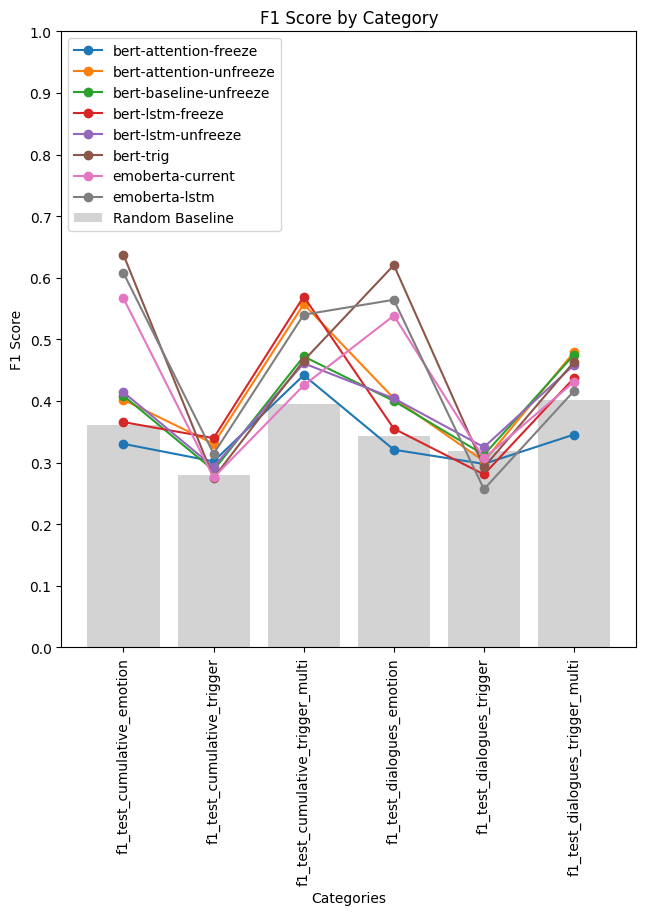

In [ ]:
baseline_freeze = test_results_aggregated.loc["bert-baseline-freeze"]


# Sample data (replace this with your actual data)
plt.figure(figsize=(10, 8))
categories = test_results.columns.tolist()
# Bar chart
plt.bar(categories, test_results_aggregated.iloc[:, test_results_aggregated.columns.get_level_values(1)=='mean'].loc['bert-baseline-freeze'].tolist(), color='lightgray', label='Random Baseline')

# Line plot
for model_name in test_results_aggregated.index.tolist():
    if model_name == "bert-baseline-freeze":
        continue
    # Get mean for the current model
    
    model_results_mean = test_results_aggregated.iloc[:, test_results_aggregated.columns.get_level_values(1)=='mean'].loc[model_name].tolist()
    plt.plot(categories, model_results_mean, marker='o', linestyle='-', label=model_name)

# plt.plot(categories, f1_score_best_list + [f1_score_best_average], marker='o', linestyle='-', color='green', label='F1 Score (Line)')


# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('F1 Score')
plt.title('F1 Score by Category')
plt.ylim(0, 1)
plt.xticks(rotation=90)
# put the legend out of the figure
plt.legend(bbox_to_anchor=(0, 1), loc='upper left',)
plt.subplots_adjust(right=0.7)
plt.yticks(np.arange(0, 1.1, 0.1))

# Adding legend

# Show the plot
plt.show()

# What?

In [266]:
# Select all the utterances that are equalt to word

word = 'i know honey, i\'m sorry.'
what_dialogues = df[df['utterances'].apply(lambda x: x.split(': ')[1].lower()) == word].index.get_level_values(0).tolist()
what_df = test_loader.dataset.data.iloc[what_dialogues]


In [208]:
class WhatDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]

In [209]:
loader = DataLoader(WhatDataset(what_df), batch_size=1, shuffle=False, collate_fn=test_loader.collate_fn)

In [227]:
torch.backends.cudnn.deterministic = True

In [241]:
# Load baseline model
baseline_model = load_model(models["bert-baseline-freeze"]["model_class"], "bert-baseline-freeze-seed-6", hyperparameters=models["bert-baseline-freeze"]["hyperparameters"])
baseline_model.eval()

/home/elements72/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.3, which is newer than your current Lightning version: v2.1.0


Using cache of size 100000 for the embedding


BertBaseline(
  (emotion_clf): CLF(
    (fc0): Linear(in_features=768, out_features=128, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (out): Linear(in_features=128, out_features=7, bias=True)
  )
  (trigger_clf): CLF(
    (fc0): Linear(in_features=768, out_features=128, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (out): Linear(in_features=128, out_features=2, bias=True)
  )
  (encoder): BertEncoder(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,),

In [254]:
# Get most difficult dialogues
data = []
count = 0
for x in test_loader:
    #print(x)
    pred = baseline_model.pred(x, None, None)
    emotions_pred = pred["emotions"].tolist()
    emotions_true = x["emotions"].tolist()
    
    utterances = [item for sublist in x["utterances"] for item in sublist]
    emotions_pred = [item for sublist in emotions_pred for item in sublist]
    emotions_true = [item for sublist in emotions_true for item in sublist]
    dialog_id = [i + count for i in range(len(x["utterances"])) for _ in x['utterances'][i]]

    count += len(x['utterances'])
    
    trigger_pred = pred["triggers"].tolist()
    trigger_true = x["triggers"].tolist()
    
    trigger_pred = [item for sublist in trigger_pred for item in sublist]
    trigger_true = [item for sublist in trigger_true for item in sublist]
    
    # Utterances, emotion_pred, emotion_true are lists 
    
    data = data + list(zip(utterances, emotions_pred, emotions_true, trigger_pred, trigger_true, dialog_id))    
    

df_what_baseline = pd.DataFrame(columns=["utterances", "emotion_pred", "emotion_true", "trigger_pred", "trigger_true", "dialog_id"], data=data)
    
df_what_baseline["emotion_correct"] = df_what_baseline["emotion_pred"] == df_what_baseline["emotion_true"]
df_what_baseline["trigger_correct"] = df_what_baseline["trigger_pred"] == df_what_baseline["trigger_true"]

df_what_baseline["emotion_pred"] = df_what_baseline["emotion_pred"].apply(lambda x: emotion_encoder.classes_[x])
df_what_baseline["emotion_true"] = df_what_baseline["emotion_true"].apply(lambda x: emotion_encoder.classes_[x] if x != 7 else "<PAD>")

# Remove rows where emotion true is <PAD>
df_what_baseline = df_what_baseline[df_what_baseline["emotion_true"] != "<PAD>"]

In [267]:
what_best_model = df[df['utterances'].apply(lambda x: x.split(': ')[1].lower()) == word]
what_best_model.drop(columns=['trigger_pred', 'trigger_true', 'trigger_correct', 'emotion_correct'], inplace=True)
what_best_model.head(3)

/tmp/ipykernel_43968/3650637752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  what_best_model.drop(columns=['trigger_pred', 'trigger_true', 'trigger_correct', 'emotion_correct'], inplace=True)


,,utterances,emotion_pred,emotion_true
dialog_id,,,,
6,1,"Monica: I know honey, I'm sorry.",anger,sadness
7,1,"Monica: I know honey, I'm sorry.",joy,sadness
8,1,"Monica: I know honey, I'm sorry.",anger,sadness


In [268]:
# Get what utterances
what_baseline = df_what_baseline[df_what_baseline['utterances'].apply(lambda x: x.split(': ')[1].lower()) == word]
what_baseline.drop(columns=['trigger_pred', 'trigger_true', 'trigger_correct', 'emotion_correct'], inplace=True)
# Set dialog_id column as index
what_baseline = what_baseline.set_index('dialog_id')

# Remove index level
what_baseline.head(3)

/tmp/ipykernel_43968/2706161549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  what_baseline.drop(columns=['trigger_pred', 'trigger_true', 'trigger_correct', 'emotion_correct'], inplace=True)


,utterances,emotion_pred,emotion_true
dialog_id,,,
6,"Monica: I know honey, I'm sorry.",sadness,sadness
7,"Monica: I know honey, I'm sorry.",sadness,sadness
8,"Monica: I know honey, I'm sorry.",fear,sadness


In [269]:
# Rename columns
what_baseline.columns = ['utterances', 'emotion_pred_baseline', 'emotion_true']
what_best_model.columns = ['utterances', 'emotion_pred_best_model', 'emotion_true']

what_baseline.reset_index(inplace=True)
what_best_model.reset_index(inplace=True)

In [270]:
merged = pd.concat([what_baseline, what_best_model], axis=1)
# Remove duplicates
merged = merged.loc[:,~merged.columns.duplicated()]
merged.drop(columns=['level_1'], inplace=True)

In [271]:
merged.head(100)

,dialog_id,utterances,emotion_pred_baseline,emotion_true,emotion_pred_best_model
0,6,"Monica: I know honey, I'm sorry.",sadness,sadness,anger
1,7,"Monica: I know honey, I'm sorry.",sadness,sadness,joy
2,8,"Monica: I know honey, I'm sorry.",fear,sadness,anger
3,9,"Monica: I know honey, I'm sorry.",fear,sadness,disgust
4,10,"Monica: I know honey, I'm sorry.",fear,sadness,joy
5,11,"Monica: I know honey, I'm sorry.",fear,sadness,disgust
6,12,"Monica: I know honey, I'm sorry.",fear,sadness,anger


In [186]:
# Get the rows where the emotion prediction is different
diff_emotion = merged[merged['emotion_pred_baseline'] != merged['emotion_pred_best_model']]

In [187]:
dialog_id = diff_emotion['dialog_id'].iloc[0]

In [188]:
# Get the dialogues with the same dialog_id
dialog = df[df.index.get_level_values(0) == dialog_id]

In [189]:
dialog

utterances  \
dialog_id                                                                                                                               
142       0  Phoebe: Hey Rach, wanna hear the new song I'm thinkin' of singing this afternoon? I wrote it this morning in the shower.   
          1  Rachel: Ok.                                                                                                                
          2  Terry: Uh, Rachel, sweetheart, could I see ya for a minute?                                                                
          3  Rachel: What's up?                                                                                                         
          4  Terry: F.Y.I..                                                                                                             
          5  Terry: I've decided to pay a professional musician to play in here on Sunday afternoons.                                   
          6  Terry: Her name is Stephanie... something.                                                                                 
          7  Terry: She's supposed to be very good.                                                                                     
          8  Rachel: But what about Phoebe?                                                                                             

            emotion_pred emotion_true  trigger_pred  trigger_true  \
dialog_id                                                           
142       0  joy          joy          0             0              
          1  joy          neutral      0             0              
          2  neutral      neutral      0             0              
          3  fear         neutral      0             0              
          4  joy          neutral      0             0              
          5  fear         neutral      0             1              
          6  joy          neutral      0             0              
          7  neutral      neutral      0             0              
          8  anger        surprise     0             0              

             emotion_correct  trigger_correct  
dialog_id                                      
142       0  True             True             
          1  False            True             
          2  True             True             
          3  False            True             
          4  False            True             
          5  False            False            
          6  False            True             
          7  True             True             
          8  False            True